# Frequency spectrum of sound using PyAudio, NumPy, and Matplotlib

[Link](https://yjlv.blogspot.com/2012/11/frequency-spectrum-of-sound-using.html)


-----

In [3]:
!pip install pyaudio


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\Käyttäjä\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [16]:
import pyaudio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [7]:
SAVE = 0.0
TITLE = ''
FPS = 25.0

nFFT = 512
BUF_SIZE = 4 * nFFT
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 44100

C:\Users\KYTTJ~1\AppData\Local\Temp/ipykernel_22172/3281047740.py:5: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('symlog', linthreshy=nFFT**0.5)


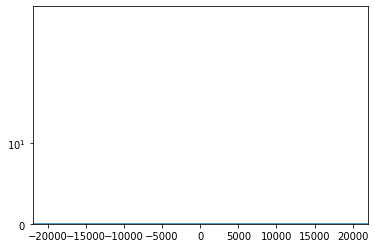

In [21]:
fig = plt.figure()
x_f = 1.0 * np.arange(-nFFT / 2 + 1, nFFT / 2) / nFFT * RATE
ax = fig.add_subplot(111, title=TITLE, xlim=(x_f[0], x_f[-1]),
                   ylim=(0, 2 * np.pi * nFFT**2 / RATE))
ax.set_yscale('symlog', linthreshy=nFFT**0.5)

line, = ax.plot(x_f, np.zeros(nFFT - 1))


In [22]:
def change_xlabel(evt):
  labels = [label.get_text().replace(u'\u2212', '')
            for label in ax.get_xticklabels()]
  ax.set_xticklabels(labels)
  fig.canvas.mpl_disconnect(drawid)
drawid = fig.canvas.mpl_connect('draw_event', change_xlabel)

In [23]:
def animate(i, line, wf, MAX_y):

  N = (int((i + 1) * RATE / FPS) - wf.tell()) / nFFT
  if not N:
    return line,
  N *= nFFT
  data = wf.readframes(N)
  print('{:5.1f}% - V: {:5,d} - A: {:10,d} / {:10,d}'.format(
    100.0 * wf.tell() / wf.getnframes(), i, wf.tell(), wf.getnframes()
  ))

  # Unpack data, LRLRLR...
  y = np.array(struct.unpack("%dh" % (len(data) / SAMPLE_SIZE), data)) / MAX_y
  y_L = y[::2]
  y_R = y[1::2]

  Y_L = np.fft.fft(y_L, nFFT)
  Y_R = np.fft.fft(y_R, nFFT)

  # Sewing FFT of two channels together, DC part uses right channel's
  Y = abs(np.hstack((Y_L[-nFFT / 2:-1], Y_R[:nFFT / 2])))

  line.set_ydata(Y)
  return line,

In [25]:
def init(line):

  # This data is a clear frame for animation
  line.set_ydata(np.zeros(nFFT - 1))
  return line,


In [26]:
p = pyaudio.PyAudio()
MAX_y = 2.0**(p.get_sample_size(FORMAT) * 8 - 1)

frames = None
wf = None
if SAVE:
  frames = int(FPS * SAVE)
  wf = wave.open('temp.wav', 'wb')
  wf.setnchannels(CHANNELS)
  wf.setsampwidth(p.get_sample_size(FORMAT))
  wf.setframerate(RATE)

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=BUF_SIZE)

ani = animation.FuncAnimation(fig, animate, frames,
    init_func=lambda: init(line), fargs=(line, stream, wf, MAX_y),
    interval=1000.0/FPS, blit=True)

In [27]:
plt.show()

stream.stop_stream()
stream.close()
p.terminate()

if SAVE:
  wf.close()